## Initial Version of the code

#### Todo:
    - Give some more values of Initial Values -> Done
    - Play With the Value of Alpha -> Done


In [1]:
#* Imports

import numpy as np 
import matplotlib.pyplot as plt #* For Plotting
import scipy as sp
from scipy import integrate #* For Solving Differential Equations
import snoop  #* For Debugging Purpose
from scipy.optimize import brentq 
from numbalsoda import lsoda_sig, lsoda, solve_ivp, dop853 #Faster Method
import numba as nb #For Speeding Up
from pathos.multiprocessing import ProcessingPool as Pool #For Multiprocessing
from itertools import product

from scipy.interpolate import CubicSpline
import scipy.integrate as integrate

In [2]:
#Parameters

mu=1.0028 #! This Value was not given in paper. I solved it 
        #! using the constraint on the total energy
M=1.
L=1.
z0=0.5
alpha=0.1  #TODO Important Parameter. 

The Hamiltonian is : <br> <br>
$\mu*(pw^2/2\mu + pz^2/2\mu + L^2/(2 \mu^2 w^2) - M/\sqrt{w^2 + z^2} + \alpha z_0 \log(\cosh(z/z_0)))$

$L= p_{\phi} \;\;\;\;\;!$

In [4]:
@nb.njit
def H(mu: np.float64,ics: np.ndarray) -> np.ndarray:
    """

    Args:
        mu (float): Mass of the Test Particle
        ics (np.ndarray): The Phase Space Coordinates of the particle
                        Shape(n,4)

    Returns:
        Energy of the particel (np.ndarray): Shape (n,)
    """

    w,z,phi,pw,pz,pphi=ics[:,0],ics[:,1],ics[:,2],ics[:,3],ics[:,4],ics[:,5]
    L= pphi

    return mu*(pw**2/(2*mu) + pz**2/(2*mu) + L**2/(2* mu**2*w**2) - M/np.sqrt(w**2 + z**2) + alpha*z0*np.log(np.cosh(z/z0)))

In [4]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L]) #* Initial conditions w,z,phi, pw,pz,pphi from paper

In [5]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [6]:
t.shape

(100000,)

In [7]:
def evolve(t: float,x: np.ndarray,alpha: int)-> np.ndarray:
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    w,z,phi,pw,pz,pphi=x
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /(mu**2 * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0

    return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [8]:
# @nb.cfunc('')
def poincare(t: float,y: np.ndarray,args:np.int32)-> float:
    """Creating Poincare Section 

    Args:
        t (float): time Step
        y (np.ndarray): Shape (n,4)
        args (np.int32) : Not needed. But used for compatibility for
                            below methods

    Returns:
        float: The value where the function gets zero (z value in this case)
    """
    return y[1]


In [9]:
sol=integrate.solve_ivp(evolve,(0.,t[-1]),ics,'LSODA',t_eval=t,events=poincare,dense_output=True,args=(alpha,),atol=1e-11,rtol=1e-11)

In [10]:
sol.y.T

array([[ 1.20000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.60000000e-01,  1.00000000e+00],
       [ 1.17007810e+00,  6.75974230e-01,  7.08631040e-01,
        -1.12471875e-02,  5.30944299e-01,  1.00000000e+00],
       [ 1.26112778e+00,  1.02332541e+00,  1.40545384e+00,
         2.01759015e-01,  1.69088261e-01,  1.00000000e+00],
       ...,
       [ 2.38091788e+00, -2.41770842e-01,  3.36382463e+04,
        -3.44708252e-02,  4.98430056e-01,  1.00000000e+00],
       [ 2.29484853e+00,  2.66247348e-01,  3.36384275e+04,
        -1.38328922e-01,  4.94796662e-01,  1.00000000e+00],
       [ 2.10654200e+00,  7.09297204e-01,  3.36386322e+04,
        -2.35216997e-01,  3.77585360e-01,  1.00000000e+00]])

In [11]:
cs= CubicSpline(sol.t,sol.y.T)

In [12]:
sol.sol(5432.3434543957),cs(5432.3434543957)

(array([3.02885980e+00, 9.38628096e-01, 1.78987241e+03, 4.74003895e-03,
        3.84191334e-02, 1.00000000e+00]),
 array([3.02887027e+00, 9.38626906e-01, 1.78987241e+03, 4.73961408e-03,
        3.84199332e-02, 1.00000000e+00]))

In [13]:
mask=sol.y_events[0][:,4]>0  #* Get those values where v_z is greater than zero

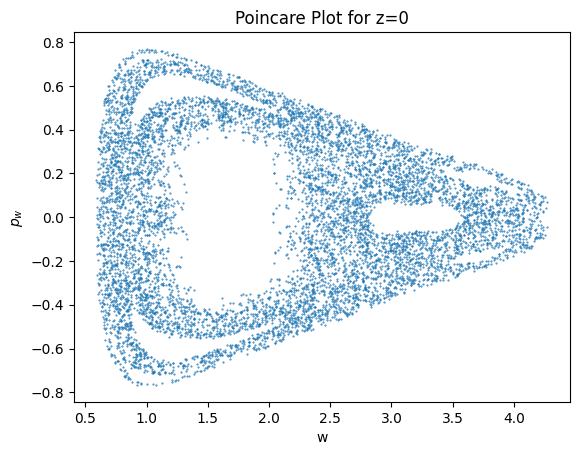

In [14]:

#* Poincare Plot
 
plt.scatter(sol.y_events[0][mask,0],sol.y_events[0][mask,3],s=0.2);
plt.title(r"Poincare Plot for z=0");
plt.xlabel(r"w");
plt.ylabel(r"$p_w$");

In [15]:
# plt.plot(sol.y[1])

In [16]:
energy=H(mu,sol.y.T) #Get the energy of given solutions

Text(0, 0.5, 'Energy')

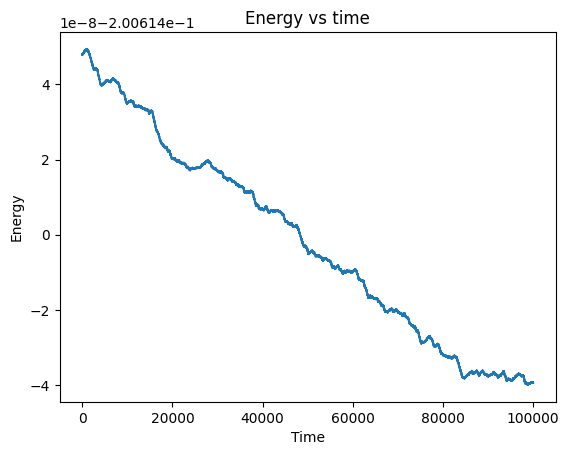

In [17]:
plt.plot(H(mu,sol.y.T)) 
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")

#* The value of energy is within -0.2 (+/- 39e^(-8))

In [18]:
np.isclose(np.diff(H(mu,sol.y.T)),0).all()
#! All the values of energy are within 1e^(-8)

True

In [ ]:

#! Faster Methods -----------------------------------

In [12]:
# The following methods generate the solutions very fast
# But they are very slow if you want to generate the Poincare
# Sections. We do not need these now. But I put it for future reference

In [ ]:
#-------------Using Multi-Processing------

In [29]:
# @nb.njit
def numba_evolve(t,x,alpha):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    w,z,pw,pz=x
    dw= pw
    dz= pz
    
    dpw= -mu*(-L**2 /(mu**2 * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))

    return np.array((dw,dz,dpw,dpz))


In [18]:
def main(u0,alpha):
    sol=solve_ivp(numba_evolve,(0.,t[-1]),u0,'LSODA',t_eval=t,events=poincare,dense_output=True,args=(alpha,),atol=1e-10,rtol=1e-10)
    return sol

In [19]:
#Some initial conditions

In [20]:
u00=np.random.uniform(1.2,2.5,5).reshape(5,1)
u01=np.random.uniform(0.49,0.76,5).reshape(5,1)
u0z=np.zeros_like(u00)
u0s=np.concatenate((u00,u0z,u0z,u01),axis=1)

In [21]:
u0s.shape

(5, 4)

In [22]:
alphas=np.array([0.1,0.01,10.0])

In [23]:
p=Pool(10)
sol=p.map(main,*zip(*product(u0s,alphas)))

In [ ]:
#------------ Using LSODA wrapper-----------------

In [65]:
#Faster Version of evolve method above
@nb.cfunc(lsoda_sig)
def faster_evolve(t,u, du,p):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    # w,z, phi,pw,pz,pphi=x
    du[0]= u[3]
    du[1]= u[4]
    du[2]= L/(mu*u[0]**2)

    du[3]= -mu*(-L**2 /(mu**2 * u[0]**3) + M*u[0]/((u[0]**2+u[1]**2)**(3/2)))
    du[4]=-mu*(M*u[1]/((u[0]**2+u[1]**2)**(3/2))+ alpha*np.tanh(u[1]/z0))
    du[5]=0.0

    # return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [66]:
funcptr=faster_evolve.address

In [67]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial conditions

In [68]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [69]:
n_events=6000

@nb.cfunc(lsoda_sig)
def poincare_event(t,u,out,p):
    for i in nb.prange(n_events):
        out[i]=u[1]

# jitted_events = nb.njit(poincare_event)
event_fcn=poincare_event.address

In [70]:
t_span=np.array([min(t),max(t)])

In [80]:
t_eval=np.arange(0,10000,1)

In [60]:
usol, success = lsoda(funcptr, u0, t,atol=1e-10,rtol=1e-10)

In [ ]:
#Now, to make the poincare plot

#---------------Work in Progress------------------


In [ ]:
idx2 = np.where(np.sign(usol[:,1][:-1]) != np.sign(usol[:,1][1:]))[0] + 1
idx1=idx2-1

In [ ]:
f=lambda t: lsoda(funcptr,u0 , np.array([0,t]), mxstep=5000000,atol=1e-10, rtol=1e-10)[0][-1,1];
t_eval=np.zeros_like(idx1)

for i in range(1,len(idx2)):
    t_eval[i]=brentq(f,t[idx1[i]],t[idx2[i]])

# t_eval=np.array(t_eval)

In [ ]:
# plt.plot(t,H(mu,usol))

In [19]:
#Lyponov Exponents

In [20]:
#First we calculate various derivatives of Hamiltonians

In [24]:
Ut=np.array([[0.,0.,0.,1.,0.,0.],
             [0.,0.,0.,0.,1.,1.],
             [-1.,0.,0.,0.,0.,-1.],
             [-1.,-1.,0.,0.,0.,-1.],
             [-1.,-1.,0.,0.,0.,0.],
             [0.,0.,0.,0.,0,-1.]])

In [25]:
eval_t=np.linspace(0,t[-1],2**17+1)

In [26]:
for i in range(6):
    for j in range(6):
        yvals=dFdx[i,j](eval_t)
        
        Ut[i,j]=integrate.romb(yvals,dx=eval_t[1]-eval_t[0])

In [27]:
Ut

array([[     0.        ,      0.        ,      0.        ,
         99999.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,  99999.        ,      0.        ],
       [-57240.99014097,      0.        ,      0.        ,
             0.        ,      0.        ,  33634.97319328],
       [-47091.94009836,   -187.38290438,      0.        ,
             0.        ,      0.        ,  57240.99014097],
       [  -187.38290438, -27329.1531727 ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [-57240.99014097,      0.        ,      0.        ,
             0.        ,      0.        , -33634.97319328]])

In [29]:
#Next Try

In [30]:
Y0=np.identity(6)

In [47]:
Y0 = Y0.reshape(-1);         # make data 1-dimensional
def odefun(t,x):
    x=x.reshape([6,6]);      # restore to matrix form

    dFdx_t=np.zeros((6,6),dtype=np.float64)
    for i in range(6):
        for j in range(6):
            dFdx_t[i,j]=dFdx[i,j](t) 
    
    dx=dFdx_t.dot(x);          # perform matrix operations
    return dx.reshape(-1);   # return 1-dimensional vector

In [ ]:
@nb.cfunc(lsoda_sig)
def odefun(t,u,du,p):
    x=u.reshape([6,6]);      # restore to matrix form

    dFdx_t=np.zeros((6,6),dtype=np.float64)
    for i in range(6):
        for j in range(6):
            dFdx_t[i,j]=dFdx[i,j](t) 
    
    du=dFdx_t.dot(x);          # perform matrix operations
    return du.reshape(-1);   # return 1-dimensional vector

In [72]:
solY=integrate.solve_ivp(odefun,[0,10**4],Y0,rtol=1e-6,atol=1e-1)

In [75]:
Utt0=solY.y.T[-1].reshape([6,6])

In [76]:
Utt0

array([[ 2.35617060e+307,  2.49470470e+306,  0.00000000e+000,
         2.93215996e+307,  2.25665406e+307,  1.00636237e+307],
       [ 6.14474551e+305,  6.50603377e+304,  0.00000000e+000,
         7.64688972e+305,  5.88521260e+305,  2.62453009e+305],
       [-2.33654005e+307, -2.47391994e+306,  1.00000000e+000,
        -2.90773052e+307, -2.23785264e+307, -9.97977809e+306],
       [ 1.72669596e+306,  1.82821928e+305,  0.00000000e+000,
         2.14880398e+306,  1.65376626e+306,  7.37502553e+305],
       [-2.33231393e+306, -2.46944534e+305,  0.00000000e+000,
        -2.90247129e+306, -2.23380501e+306, -9.96172758e+305],
       [-9.85883550e+306, -1.04384985e+306,  0.00000000e+000,
        -1.22689260e+307, -9.44243222e+306, -4.21088398e+306]])

In [78]:
eks=np.identity(6)